# Reconstrution Network

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')  # Move up one directory level to root directory of project
print("This path should be the root directory: ", os.getcwd())



This path should be the root directory:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


In [3]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils





#import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
#from torchvision import transforms
#from torch.utils.data import DataLoader
import torchvision.utils as vutils
import datetime




from data.reconstruction_dataset import *
from models.unet import UNet1



### Dataset
Creating the dataset object and applzing transformations to the data.

In [4]:
csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

<Figure size 640x480 with 0 Axes>

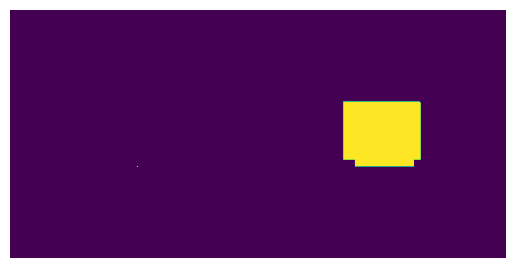

In [5]:
example_data = dataset[0]

plt.figure()
show_datapair(example_data['image'], example_data['label'])
plt.show()

### Dataloader
Creating a dataloader based on the dataset for batch processing.

TODO: Remove spacing in figure.

torch.Size([16, 1, 256, 256])
torch.Size([1, 256, 256])


/home/daniel/Documents/TUM/ADLR/tum-adlr-02/data/reconstruction_dataset.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


<Figure size 1x19096 with 0 Axes>

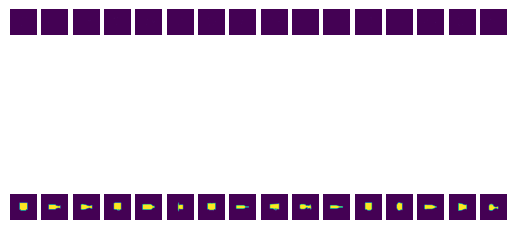

In [7]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

batch = next(iter(dataloader))
print(batch['image'].shape)

show_datapair_batch(next(iter(dataloader)))


In [8]:
### Initialize Network

In [10]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet1().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set up TensorBoard
writer = SummaryWriter(f'runs/U-Net_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')

print(device)

cpu


In [11]:
#### Training

Epoch [1/50], Step [1/2225], Loss: 0.1600


<Figure size 640x480 with 0 Axes>

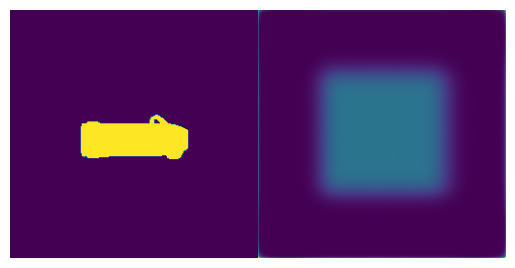

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        # todo change datatypes in dataset not in dataloader, use proper datatypes, output should be segmentation
        img_A = batch['image'].float()
        img_B = batch['label'].float()
        img_A = img_A.to(device)
        img_B = img_B.to(device)

        
        
        optimizer.zero_grad()
        outputs = model(img_A)
        loss = criterion(outputs, img_B)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 0:  # Log every 10 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
            writer.add_scalar('training_loss', running_loss / 10, epoch * len(dataloader) + i)
            running_loss = 0.0

            # Log reconstructed images
            img_grid = vutils.make_grid(outputs)
            writer.add_image('reconstructed_images', img_grid, global_step=epoch * len(dataloader) + i)

            # ploting images like this until it works with tensorboard
            plt.figure()
            show_datapair(img_B[0], outputs[0].detach().numpy())
            plt.show()

# Validation step can be added here similarly and log validation loss

writer.close()